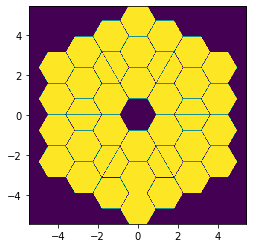

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import numpy as np
import viper_detector
from scipy.ndimage import gaussian_filter
import time
from utils import *
import copy
import hcipy
import os.path
import csv
from astropy.io import fits
from processing import *
import time
from Keck_aperture import *

In [2]:
print(hcipy.__version__)

0.4.1.dev76+gf398e82


# User Inputs

In [3]:
## Metadata
name = "Keck AO Residuals" # filename you want to write, no extension
overwrite = True # True if you wish to overwrite files with the same name
detector_name = "SAPHIRA" 

## Properties for EMCCD 
# EM_gain = None # Set EM Gain for EMCCDs. If running a detector with no EM Gain, set = None
# EM_saturation = None # Set behavior when full well depth is reached. None means saturated pixels will be automatically set to full well depth. np.nan means saturated pixels will be set to np.nan

## Properties of the Focal Grid
q=2 # Number of pixels per resolution element
nairy = 20 #The spatial extent of the grid radius in resolution elements (=lambda f/D)

## Exposure time and total number of exposures
exposure_time = 0.01 # Exposure time in seconds. For AO systems ignore this for the time being
exposure_total = 200 # Total number of exposures
micro_integration_time = 1./1000 #Set equal to AO Frequency
## Setting Up the Atmosphere
seeing = 0.6
outer_scale = 50. # (meter) 
velocity = 10. # (m/s) 
                                    
## Setting up the telescope
pupil_diameter = 9.96 # (meter)
f_number = 15 # effective focal ratio
grid_size = 200 # Number of pixels per dimension
filter_name = 'V' # Name of filter. Not applicable for IR detectors
telescope_pupil_generator = make_keck_aperture(normalized = False)

## Add a Primary and Companion
# Primary parameters
mag = 5 # Magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] # I, Q, U, V
# Companion parameters
contrast = 0.
stokes_ps = [1.,0.,0.,0.] # I, Q, U, V
angular_separation= 2 # Lambda/D

## AO Parameters
#leaky integrator parameters
gain = 0.4
leakage = 0.999

#AO loop speed: = Micro-Integration Time 
dt= micro_integration_time

num_actuators = 21 # set the number of actuators

# setup Pyramid WFS
pixels_pyramid_pupils=40 # number of pixels across the pupil; want 120 %(mod) pixels_pyramid_pupils =0

mld=6 # modulation radius in lambda/D 

modsteps = 12 #keep this as a factor of 4. Significantly increases computation time.


# Helper Functions

The following defines some some important helper functions. Please run this section as well. It is hidden to declutter the notebook for you.

bin(imin,fbin) This binning function takes an image of a certain size and bins it down by a certain amount.

pyramid_slopes (image) This function calculates the slopes for our pyramid wavefront sensor.

plot_slopes (image) This function helps to make data that is easy to plot.

In [4]:
#@title
 #helper functions 

def bin(imin,fbin): 

    ''' Parameters
    ----------
    imin : 2D numpy array
         The 2D image that you want to bin
    fbin : int
         
    
    Returns
    -------
    out : 2D numpy array
        the 2D binned image
        '''
    out=np.zeros((int(imin.shape[0]/fbin),int(imin.shape[1]/fbin)))
   #  begin binning
    for i in np.arange(fbin-1,imin.shape[0]-fbin,fbin):
        for j in np.arange(fbin-1,imin.shape[1]-fbin,fbin):
            out[int((i+1)/fbin)-1,int((j+1)/fbin)-1]=np.sum(imin[i-int((fbin-1)/2):i+int((fbin-1)/2),j-int((fbin-1)/2):j+int((fbin-1)/2)])
    return out


def pyramid_slopes(image,pixels_pyramid_pupils, diameter):

    ''' Parameters
    ----------
    image : 1D numpy array
         The flatted image of the pyramid wfs pupils
           
    Returns
    -------
    slopes : 1D numpy array
        x- and y- slopes inside the pupil stacked onto of eachother for 1D array
        '''
    D = diameter
    pyramid_plot_grid = make_pupil_grid(pixels_pyramid_pupils*2, D) #hardcoded for now/ease

    pyr1=circular_aperture(0.5*D,[-0.25*D,0.25*D])(pyramid_plot_grid)
    pyr2=circular_aperture(0.5*D,[0.25*D,0.25*D])(pyramid_plot_grid)
    pyr3=circular_aperture(0.5*D,[-0.25*D,-0.25*D])(pyramid_plot_grid)
    pyr4=circular_aperture(0.5*D,[0.25*D,-0.25*D])(pyramid_plot_grid)
    N=4*np.sum(pyr1[pyr1>0])
    norm=(image[pyr1>0]+image[pyr2>0]+image[pyr3>0]+image[pyr4>0])/N
    sx=(image[pyr1>0]-image[pyr2>0]+image[pyr3>0]-image[pyr4>0])
    sy=(image[pyr1>0]+image[pyr2>0]-image[pyr3>0]-image[pyr4>0])
    return np.array([sx,sy]).flatten()

def plot_slopes(slopes,pixels_pyramid_pupils, diameter):
    ''' 
    Only want if we decide to plot the slopes. 

    Parameters
    ----------
    slopes : 1D numpy array
         The flatted slopes produced by pyramid_slopes(). 
           
    Returns
    -------
    slopes : 1D numpy array
        x- and y- slopes mapped within their pupils for easy plotting
    '''
    D=diameter
    mid=int(slopes.shape[0]/2)
    pyramid_plot_grid = make_pupil_grid(pixels_pyramid_pupils, D)
    pyr_mask=circular_aperture(D)(pyramid_plot_grid)
    sx=pyr_mask.copy()
    sy=pyr_mask.copy()
    sx[sx>0]=slopes[0:mid]
    sy[sy>0]=slopes[mid::]
    return [sx,sy]



The hidden cell below contains the function make_command_matrix().

In [5]:
#@title

def make_command_matrix(deformable_mirror, mpwfs,modsteps,wfs_camera,wf,pixels_pyramid_pupils, diameter):

    probe_amp = 0.02 * wf.wavelength
    response_matrix = []
    num_modes=deformable_mirror.num_actuators

    for i in range(int(num_modes)):
        slope = 0

        for s in [1, -1]:
            amp = np.zeros((num_modes,))
            amp[i] = s * probe_amp
            deformable_mirror.flatten()
            deformable_mirror.actuators = amp

            dm_wf = deformable_mirror.forward(wf)
            wfs_wf = mpwfs.forward(dm_wf)

            for m in range (modsteps) :
                wfs_camera.integrate(wfs_wf[m], 1)

            image_nophot = wfs_camera.read_out()
            image_nophot/=image_nophot.sum()
            D = diameter  
            sxy=pyramid_slopes(image_nophot,pixels_pyramid_pupils, D)

            slope += s * (sxy-pyr_ref)/(2*probe_amp)#indent  #these are not really slopes; this is just a normalized differential image

        response_matrix.append(slope.ravel())#indet

    response_mtx= ModeBasis(response_matrix)
    rcond = 1e-3

    reconstruction_matrix = inverse_tikhonov(response_mtx.transformation_matrix, rcond=rcond)

    return reconstruction_matrix

# Generating the FITS File, Atmosphere, Focal Grid, Detector

In [6]:
## Some math to define additional parameters
collecting_area = np.pi * (3.048**2 - 0.9779**2)
effective_focal_length = pupil_diameter * f_number # (meter)
#wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)
wavelength = 1.5E-6
print("Filter Wavelength = ", wavelength)
k=2*np.pi/wavelength

## Generate name strings
fits_name = name + ".fits"

## Checking to see if filenames exists
if os.path.isfile(fits_name):
    if overwrite:
        print("File name ", fits_name, " already exists. Preparing to overwrite.") 
        os.remove(fits_name)
    else:
        print("Error, file name ",fits_name," already exists. Overwrite was not allowed.")
        print("Exiting program...")
        quit()

## Generating the pupil grid
print("Generating the pupil grid")
pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

## Adjust spiders to represent Keck pupil
print("Generating the telescope pupil")
telescope_pupil = telescope_pupil_generator(pupil_grid)

## Generating the atmosphere
print("Generating the atmosphere")
fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
print("Fried Parameter = ", fried_parameter)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
tau0 = 0.314 * fried_parameter/velocity
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

##Generating the focal grid
print("Generating the focal grid")
focal_grid = make_focal_grid(q=q, 
                             num_airy=nairy,
                            spatial_resolution = wavelength / pupil_diameter)
# Define the Detector
# call_detector = "viper_detector." + detector_name + "(focal_grid, " + f'"{filter_name}"'
# if EM_gain == None:
#     call_detector += ")"
# else:
#     call_detector += ", " + str(EM_gain)+ ", " + str(EM_saturation) +")"
# print(call_detector)
# detector = eval(call_detector) 

## Generating the propagator
print("Generating the propagator")
# prop = FraunhoferPropagator(pupil_grid, focal_grid, 
#                             focal_length=effective_focal_length)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

## Generating wavefront of primary and companion
print("Generating wavefront of primary and companion")
# pupil_wavefront = Wavefront(telescope_pupil, wavelength,
#                             input_stokes_vector=stokes_vector)
pupil_wavefront = Wavefront(telescope_pupil, wavelength)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,)#In photons/s
# wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
#                       wavelength,
#                       input_stokes_vector=stokes_ps)
# wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,)# (photons/s)

#reference image and the max for plotting the psf later as well as strehl ratio calculation 
im_ref= prop.forward(pupil_wavefront)
norm= np.max(im_ref.intensity)


Filter Wavelength =  1.5e-06
Generating the pupil grid
Generating the telescope pupil
Generating the atmosphere
Fried Parameter =  0.5053487753053861
Generating the focal grid
Generating the propagator
Generating wavefront of primary and companion


# Setting up the AO

In [7]:
#make the DM
actuator_spacing = pupil_diameter / num_actuators
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators, actuator_spacing) 
deformable_mirror = DeformableMirror(influence_functions)

modradius = mld*wavelength/pupil_diameter # modulation radius in radians;
pwfs_grid = make_pupil_grid(2*pixels_pyramid_pupils,2*pupil_diameter) 
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, wavelength_0=wavelength, q=q, num_airy = nairy)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs,modradius,modsteps)   
wfs_camera = viper_detector.SAPHIRA(pwfs_grid)
detector = wfs_camera

#bin our pyramid image
pyramid_plot_grid = make_pupil_grid(pixels_pyramid_pupils*2, pupil_diameter)

#commands to modulate the PyWFS, get an image out, and calculate a reference slope
print("Modulating PyWFS")
start = time.perf_counter()
for m in range (modsteps) :
    print("Percent complete = ", round((m+1)/modsteps * 100, 3), end = '\r')
    wfs_camera.integrate(mpwfs(pupil_wavefront)[m], 1)
    #wfs_camera.integrate(mpwfs(wf_planet)[m], 1)
pyr_ref = wfs_camera.read_out()
pyr_ref=pyramid_slopes(pyr_ref/pyr_ref.sum(),pixels_pyramid_pupils, pupil_diameter)

stop = time.perf_counter()
print("Runtime for Modulating PyWFS = ", stop - start)
print("Making Command Matrix")
start = time.perf_counter()
#Make command matrix for controller. 
#This code will have to be rerun everytime you change a parameter about the PyWFS or DM. 
#Just run this code & do not peak at the function that does the work for you. 
CM=make_command_matrix(deformable_mirror, mpwfs, modsteps,wfs_camera,pupil_wavefront,pixels_pyramid_pupils, pupil_diameter)
stop = time.perf_counter()
print("Runtime for making Command Matrix = ", stop - start)

Modulating PyWFS
Runtime for Modulating PyWFS =  0.9039248786866665
Making Command Matrix
Runtime for making Command Matrix =  74.38324971776456


# Generating FITS File

In [8]:
## Create the FITS file
print("Creating the FITS file")
hdr = fits.Header()
hdr['Title'] = name
hdr['Author'] = "Written by Kyle Lam."
hdr['DetName'] = detector_name + " # Name of detector"
hdr['DetType'] = str(detector.detector_type) + " # Type of detector"
hdr['FPS'] = str(detector.max_fps) + " # Readout speed of the detector in fps"
hdr['DetSize'] = str(detector.detector_size) + " # width of shortest side of detector."
hdr['q'] = str(q) + " # Number of pixels per resolution element"
hdr['NAiry'] = str(nairy) + " # The spatial extent of the grid radius in resolution elements"
hdr['AOTime'] = str(micro_integration_time) + " # Time of integration of wfs for AO system"
hdr['NumExpos'] = str(exposure_total) + " # Total Number of Exposures"
hdr['Seeing'] = str(seeing) + " # Seeing"
hdr['OutScale'] = str(outer_scale) + " # Outer Scale"
hdr['Velocity'] = str(velocity) + " # Wind Velocity"
hdr['PupDiamt'] = str(pupil_diameter) + " # Pupil Diameter"
hdr['FNum'] = str(f_number) + " # F Number"
hdr['GridSize'] = str(grid_size) + " # Grid Size"
hdr['FiltName'] = str(filter_name) + " # Filter Name"
hdr['QE'] = str(detector.QE) + " # Quantum Efficiency"
hdr['DarkCurr'] = str(detector.dark_current_rate) + " # Dark Current"
hdr['RdNoise'] = str(detector.read_noise) + " # Read Noise"
hdr['FltField'] = str(detector.flat_field) + "# Flat Field"
hdr['PhtNoise'] = str(detector.include_photon_noise) + " # Photon Noise"
hdr['PriMag'] = str(mag) + " # Magnitude of Primary"
hdr['Wavelnth'] = str(wavelength) + " # Wavelength"
hdr['Shutter'] = str(detector.shutter_type) + " # Shutter Type"
hdr['Gain'] = str(gain) + " # AO Gain"
hdr['Leakage'] = str(leakage) + " # AO Leakage"
hdr['NumActu'] = str(num_actuators) + " # Number of Actuators on one side"
hdr['PixPyra'] = str(pixels_pyramid_pupils) + " # Number of Pixels across the Pyramid Pupil"
hdr['ModRad'] = str(mld) + " # modulation radius"
hdr['modsteps'] = str(modsteps) + " # Modulation Steps"
empty_primary = fits.PrimaryHDU(header=hdr)
hdul = fits.HDUList([empty_primary])
print("FITS File Created")

Creating the FITS file
FITS File Created


# Generating AO

In [136]:
exposure_total = 50
num_iterations = exposure_total #number of iterations in our simulation
sr=[] # so we can find the average strehl ratio

# create figure
fig=plt.figure(figsize=(28,8))
# generate animation object; two optional backends FFMpeg or GifWriter. 
#anim = FFMpegWriter('AO_simulations_standard.mp4', framerate=3)
anim = GifWriter('AO_simulations_standard.gif', framerate=3)
AO_res=[]
layer.t = 0
deformable_mirror.flatten()
start = time.perf_counter()
rms = []
for timestep in range(num_iterations): 
    print("Percent complete = ", round((timestep+1)/num_iterations * 100, 3), end = '\r')
    #get a clean wavefront
    wf_in=pupil_wavefront.copy()

    #evolve the atmospheric turbulence
    layer.t += dt
    
    #pass the wavefront through the turbulence
    wf_after_atmos = layer.forward((wf_in))
    
    #pass the wavefront through the DM for correction
    wf_after_dm = deformable_mirror.forward(wf_after_atmos)

    #send the wavefront containing the residual wavefront error to the PyWFS and get slopes
    wfs_wf = mpwfs.forward(wf_after_dm)
    for mmm in range (modsteps) :
              wfs_camera.integrate(wfs_wf[mmm], dt/modsteps)
    wfs_image = wfs_camera.read_out()   
    slopes = pyramid_slopes(wfs_image/wfs_image.sum(),pixels_pyramid_pupils, pupil_diameter) -pyr_ref 
    slopes = slopes.ravel()
    dm_before = deformable_mirror.opd
    res=layer.phase_for(wavelength)/k-deformable_mirror.opd #units:meters; use this to save to avoid phase wrapping that is in the electric field of wf
    #res=wf_after_dm.phase/k

    #Leaky integrator to calculate new DM commands    
    deformable_mirror.actuators =  leakage*deformable_mirror.actuators - gain * CM.dot(slopes)
    
    image_hdu = fits.ImageHDU(res*telescope_pupil)
    hdul.append(image_hdu)
    dm_opd.append(deformable_mirror.opd)
    
    good_res = image_hdu.data[np.where(np.array(telescope_pupil))]
    good_res_mn = good_res - np.mean(good_res)
    rms.append(float((np.sqrt(np.mean(good_res_mn**2)))))

    # Propagate to focal plane
    propagator = prop
    wf_focal = propagator.forward(wf_after_dm )
    
    #calculate the strehl ratio to use as a metric for how well the AO system is performing. 
    strehl_foc=get_strehl_from_focal(wf_focal.intensity/norm,im_ref.intensity/norm)
    sr.append(strehl_foc)
    imshow_field(telescope_pupil)
    #plot the results                
    if timestep % 1 == 0: #change this if you want to have more or less frames saved to the image. 
        plt.close(fig)
        fig=plt.figure(figsize=(30,24))
        plt.suptitle('Time %.2f s / %d s' % (timestep*dt, dt*num_iterations))

#         plt.subplot(2,3,4)
#         plt.title('WFS slopes')
#         sxy=np.asarray(plot_slopes(slopes,pixels_pyramid_pupils, pupil_diameter)).reshape((2,pixels_pyramid_pupils,pixels_pyramid_pupils))
#         plt.imshow(sxy.reshape((2*pixels_pyramid_pupils,pixels_pyramid_pupils)).transpose())
#         plt.colorbar()
    
        plt.subplot(2,3,3)
        plt.title('Residual wavefront error [meters]')
        imshow_field(res*telescope_pupil, cmap='RdBu', vmin = -.5e-6, vmax = .5e-6)
        plt.colorbar()
        
#         plt.subplot(2,3,1)
#         plt.title("Wavefront Phase / k before DM")
#         imshow_field(telescope_pupil*wf_after_atmos.phase/k, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
#         plt.colorbar()
        
        plt.subplot(2,3,6)
        plt.title('Inst. PSF; Strehl %.2f'% (np.mean(np.asarray(sr))))
        imshow_field(np.log10(wf_focal.intensity/norm), cmap='inferno')
        plt.colorbar()
        
        plt.subplot(2,3,4)
        plt.title('RMS Residual Wavefront Error [meters]')
        plt.plot(rms)

#         plt.subplot(2,3,5)
#         plt.title("Deformable Mirror.opd after actuators")
#         imshow_field(deformable_mirror.opd*telescope_pupil, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
#         plt.colorbar()

        
        plt.subplot(2,3,2)
        plt.title("Deformable_Mirror.opd before actuators")
        imshow_field(telescope_pupil*dm_before, cmap = 'RdBu')
        plt.colorbar()
        
        
        plt.subplot(2,3,1)
        plt.title("Layer.phase for wavelength")
        imshow_field(layer.phase_for(wavelength)/k, cmap = 'RdBu', )
        plt.colorbar()
        
        plt.subplots_adjust(hspace=0.3)
        anim.add_frame()
#plt.suptitle('Gain = %.2f' % (gain)) # can change this to be the parameter you are varying
#plt.savefig('AO_vary_gain%.2f.png' % (gain)) #example to save the last figure to see how the parameter varied your performance

plt.close()
anim.close()
anim
stop = time.perf_counter()
print("Time Elapsed = ", stop-start)

# plt.plot(np.array(sr))
# plt.show()

Time Elapsed =  52.617739957757294


In [77]:
# ## Write the FITS file
# print()
# print("Writing the FITS file")
# hdul.writeto(fits_name)
# header_name = name + "_Header.txt"
# hdul[0].header.totextfile(header_name, endcard = False, overwrite = True)
# print("FITS file", fits_name,  "generated.")

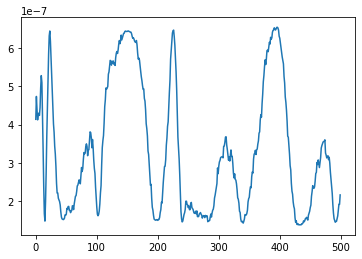

In [78]:
plt.plot(rms)

In [123]:
#reset the atmosphere
layer.t = 0
#Flatten the deformable mirror
deformable_mirror.flatten()

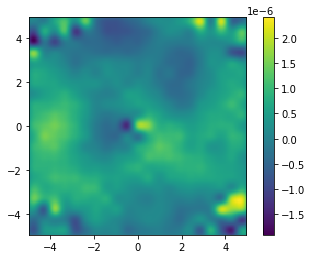

In [130]:
imshow_field(deformable_mirror.opd)
plt.colorbar()

In [131]:
#get a clean wavefront
wf_in=pupil_wavefront.copy()

#evolve the atmospheric turbulence
layer.t += dt

#pass the wavefront through the turbulence
wf_after_atmos = layer.forward((wf_in))
#pass the wavefront through the DM for correction
wf_after_dm = deformable_mirror.forward(wf_after_atmos)
dm_before = deformable_mirror.opd
#send the wavefront containing the residual wavefront error to the PyWFS and get slopes
wfs_wf = mpwfs.forward(wf_after_dm)
for mmm in range (modsteps) :
          wfs_camera.integrate(wfs_wf[mmm], dt/modsteps)
wfs_image = wfs_camera.read_out()   
slopes = pyramid_slopes(wfs_image/wfs_image.sum(),pixels_pyramid_pupils, pupil_diameter) -pyr_ref 
slopes = slopes.ravel()

res=layer.phase_for(wavelength)/k-deformable_mirror.opd #units:meters; use this to save to avoid phase wrapping that is in the electric field of wf
#res=wf_after_dm.phase/k

#Leaky integrator to calculate new DM commands    
deformable_mirror.actuators =  leakage*deformable_mirror.actuators - gain * CM.dot(slopes)

image_hdu = fits.ImageHDU(res*telescope_pupil)
hdul.append(image_hdu)
rms = float((np.sqrt(np.mean(image_hdu.data[np.where(np.array(telescope_pupil))]**2))))

# Propagate to focal plane
propagator = prop
wf_focal = propagator.forward(wf_after_dm )

#calculate the strehl ratio to use as a metric for how well the AO system is performing. 
strehl_foc=get_strehl_from_focal(wf_focal.intensity/norm,im_ref.intensity/norm)
sr = strehl_foc


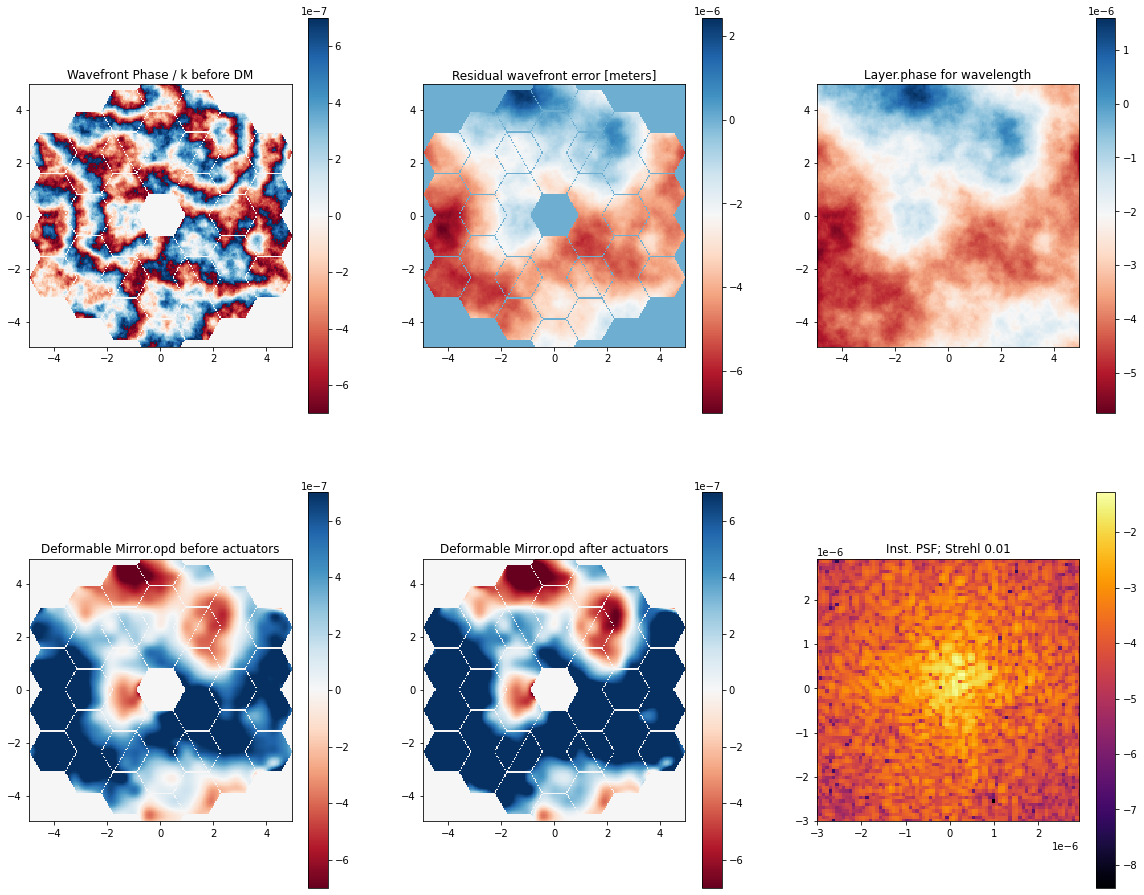

In [132]:
fig=plt.figure(figsize=(20,16))
# plt.subplot(2,3,1)
# plt.title('WFS slopes')
# sxy=np.asarray(plot_slopes(slopes,pixels_pyramid_pupils, pupil_diameter)).reshape((2,pixels_pyramid_pupils,pixels_pyramid_pupils))
# plt.imshow(sxy.reshape((2*pixels_pyramid_pupils,pixels_pyramid_pupils)).transpose())
# plt.colorbar()

plt.subplot(2,3,1)
plt.title("Wavefront Phase / k before DM")
imshow_field(telescope_pupil*wf_after_atmos.phase/k, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
plt.colorbar()

plt.subplot(2,3,2)
plt.title('Residual wavefront error [meters]')
imshow_field(res*telescope_pupil, cmap='RdBu')
plt.colorbar()

plt.subplot(2,3,6)
plt.title('Inst. PSF; Strehl %.2f'% (np.mean(np.asarray(sr))))
imshow_field(np.log10(wf_focal.intensity/norm), cmap='inferno')
plt.colorbar()

# plt.subplot(2,3,4)
# plt.title('RMS Residual Wavefront Error [meters]')
# if len(rms)>20:
#     plt.xlim(len(rms)-20, len(rms))
# plt.plot(rms)

plt.subplot(2,3,4)
plt.title("Deformable Mirror.opd before actuators")
imshow_field(dm_before*telescope_pupil, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
plt.colorbar()

plt.subplot(2,3,5)
plt.title("Deformable Mirror.opd after actuators")
imshow_field(deformable_mirror.opd*telescope_pupil, cmap = 'RdBu', vmin = -7e-7, vmax = 7e-7)
plt.colorbar()


plt.subplot(2,3,3)
plt.title("Layer.phase for wavelength")
imshow_field(layer.phase_for(wavelength)/k, cmap = 'RdBu', )
plt.colorbar()